In [39]:
# Author : Paul-Antoine Nguyen

# This script considers all the products a user has ordered
#
# We train a model computing the probability of reorder on the "train" data
#
# For the submission, we keep the orders that have a probability of
# reorder higher than a threshold


import numpy as np
import pandas as pd
import lightgbm as lgb
IDIR = '../input/'

FEATURES_PATH = './features2/'

In [40]:
print('loading prior')
priors = pd.read_csv(IDIR + 'order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading train')
trains = pd.read_csv(IDIR + 'order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading orders')
orders = pd.read_csv(IDIR + 'orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

print('loading products')
products = pd.read_csv(IDIR + 'products.csv', dtype={
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'aisle_id', 'department_id'])

print('priors {}: {}'.format(priors.shape, ', '.join(priors.columns)))
print('orders {}: {}'.format(orders.shape, ', '.join(orders.columns)))
print('train {}: {}'.format(trains.shape, ', '.join(trains.columns)))


loading prior
loading train
loading orders
loading products
priors (32434489, 4): order_id, product_id, add_to_cart_order, reordered
orders (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
train (1384617, 4): order_id, product_id, add_to_cart_order, reordered


In [41]:
priors = pd.merge(priors, orders, on="order_id", how="inner")

In [42]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


## User basket average

In [44]:
orders_count = priors.groupby('order_id')['product_id'].count()
orders_prior = orders[orders.eval_set == "prior"]
orders_prior['item_count'] = orders_prior['order_id'].map(orders_count)
user_basket_avg = orders_prior.groupby('user_id')[['item_count']].mean()
user_basket_avg.rename(columns={"item_count": "basket_size_avg"}, inplace=True)

order_id
2     9
3     8
4    13
5    26
6     3
Name: product_id, dtype: int64

## Order product features

In [ ]:
user_info = orders[orders.eval_set == "prior"].groupby('user_id') \
        .agg({'order_number': np.max}) \
        .rename(columns={'order_number': 'user_orders'})
        
user_info.reset_index(inplace = True)
user_info = pd.merge(user_info, orders[orders.eval_set != 'prior'][['user_id', 'eval_set', 'days_since_prior_order']],
                    on='user_id', how='inner')
user_info.rename(columns={'days_since_prior_order': 'time_since_last_order'}, inplace=True)

In [ ]:
user_info.head()

In [ ]:
user_info.to_csv(FEATURES_PATH + "user_info.csv")

In [ ]:
up_info = pd.DataFrame(priors.groupby(['user_id', 'product_id']).size().astype(np.int16), columns=['up_orders'])
up_info[['up_first_order', 'up_last_order']] = priors.groupby(['user_id', 'product_id']).order_number.agg([np.min, np.max])
up_info['up_average_cart_order'] = priors.groupby(['user_id', 'product_id']).add_to_cart_order.mean().astype(np.float32)

up_info.reset_index(inplace = True)
up_info.user_id = up_info.user_id.astype(np.int32)
up_info.product_id  = up_info.product_id.astype(np.int32)

In [ ]:
up_info = pd.merge(up_info, user_info, on='user_id', how='left')
up_info['up_order_rate'] = (up_info.up_orders/up_info.user_orders).astype(np.float32)
up_info['up_orders_since_last_order'] = (up_info.user_orders - up_info.up_last_order).astype(np.float32)
up_info['up_order_rate_since_first_order'] = (up_info.up_orders / (up_info.user_orders - up_info.up_first_order + 1)).astype(np.float32)

In [ ]:
trains = pd.merge(trains, orders[['order_id', 'user_id']], on = 'order_id', how='left')
up_info = pd.merge(up_info, trains[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')
up_info.reordered.fillna(0, inplace = True)

In [ ]:
up_info.to_csv(FEATURES_PATH + "up_info.csv")

## Load data

In [3]:
up_info = pd.read_csv(FEATURES_PATH + "up_info.csv", dtype={
    'user_id': np.int32,
    'product_id': np.int32,
    'up_orders': np.int16,
    'up_average_cart_order':np.float32,
    'up_order_rate': np.float32,
    'up_orders_since_last_order':np.float32,
    'up_order_rate_since_first_order': np.float32,
    'user_orders': np.int16,
    'time_since_last_order': np.float32,
   
})

In [7]:
up_info.reordered.fillna(0, inplace=True)
up_info.head()

,Unnamed: 0,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_order,user_orders,eval_set,time_since_last_order,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,reordered
0,0,1,196,10,1,10,1.400000,10,train,14.0,1.0,0.0,1.000000,1.0
1,1,1,10258,9,2,10,3.333333,10,train,14.0,0.9,0.0,1.000000,1.0
2,2,1,10326,1,5,5,5.000000,10,train,14.0,0.1,5.0,0.166667,0.0
3,3,1,12427,10,1,10,3.300000,10,train,14.0,1.0,0.0,1.000000,0.0
4,4,1,13032,3,2,10,6.333333,10,train,14.0,0.3,0.0,0.333333,1.0


In [8]:
up_info.memory_usage().sum()/1000000

958.172696

In [14]:
features = ['up_orders', 'up_average_cart_order', 'user_orders', 'time_since_last_order', 'up_order_rate', 'up_orders_since_last_order', 
            'up_order_rate_since_first_order']
up_info_train = up_info[up_info.eval_set == "train"][features + ["reordered"]]
train_data = up_info_train[features]
train_label = up_info_train["reordered"]

In [18]:
train_data.head()

,up_orders,up_average_cart_order,user_orders,time_since_last_order,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order
0,10,1.400000,10,14.0,1.0,0.0,1.000000
1,9,3.333333,10,14.0,0.9,0.0,1.000000
2,1,5.000000,10,14.0,0.1,5.0,0.166667
3,10,3.300000,10,14.0,1.0,0.0,1.000000
4,3,6.333333,10,14.0,0.3,0.0,0.333333


In [19]:
print('formating for lgb')
d_train = lgb.Dataset(train_data, label=train_label)
#d_train.save_binary(FEATURES_PATH +  'train.bin')

formating for lgb


In [20]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 100

print('light GBM train :-)')
bst = lgb.train(params, d_train, ROUNDS)

light GBM train :-)


In [23]:
bst.save_model(FEATURES_PATH+ 'trained_model.txt')

In [84]:
test_data = up_info[up_info.eval_set == "test"][['user_id', 'product_id'] + features]

In [85]:
print('light GBM predict')
preds = bst.predict(test_data[features])
preds

light GBM predict


array([ 0.02593077,  0.06310495,  0.09914106, ...,  0.00674819,
        0.01007783,  0.0110262 ])

In [ ]:
test_orders= orders[orders.eval_set == 'test']

In [116]:
test_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [88]:
prediction = pd.DataFrame()
prediction[['user_id', 'product_id']] = test_data[['user_id', 'product_id']]
prediction['proba'] = preds
prediction.sort_values(by=['user_id', 'proba'], ascending=[True, False], inplace=True)

In [117]:
prediction = pd.merge(prediction, test_orders[['order_id', 'user_id']], on="user_id", how='left')

### Recommendation using average user basket

In [105]:
products = []
count = 0
for _,row in test_orders[['user_id', 'order_id']].iterrows():
    count += 1
    if (count)%10000 == 0:
        print(count)    
    
    user_id, order_id = row['user_id'], row['order_id']
    n = int(user_basket_avg.ix[user_id].basket_size_avg)+1
    products.append(list(prediction[prediction.user_id == user_id].product_id[:n]))

10000
20000
30000
40000
50000
60000
70000


In [106]:
# create submission
submission = pd.DataFrame()
submission['order_id'] = test_orders['order_id']
submission['products'] = [' '.join([str(x) for x in p]) for p in products]
submission.sort_values(by='order_id', inplace = True)
submission.to_csv(FEATURES_PATH + 'submission.csv', index=False)

In [107]:
submission

,order_id,products
611292,17,13107 21463 38777 26429 39275 21709 47766
584613,34,44663 39475 16083 47766 2596 47792 21137 43504...
3102779,137,23794 41787 24852 38689 5134 2326 25890 29594 ...
1929637,182,9337 39275 5479 47672 13629 33000 41149 47209 ...
590591,257,49235 24852 27104 45013 29837 27966 37646 3947...
1888538,313,45007 12779 21903 46906 13198 28535 30391 25890
2880687,353,35561 40688 33000 48183 17302
924638,386,47766 38281 15872 45066 21479 42265 40759 2485...
2009806,414,20392 20564 21230 21709 33320 31730 27845 2137...
556925,418,40268 47766 30489 12036 45364 1503 13702 41950...


#### Feature importance

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline

Plot feature importances...


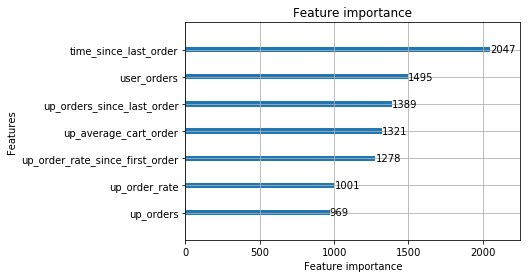

In [113]:
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=10)
plt.show()


### Recommendation using threshold

In [144]:
threshold = 0.21
recommend = prediction[prediction.proba >= threshold].groupby('order_id').product_id.apply(list)

In [164]:
recommend_df = pd.DataFrame()
recommend_df["count"] = prediction.groupby('order_id').size()
recommend_df['product_list'] = recommend


,count,product_list
order_id,,
17,21,"[13107, 21463]"
34,78,"[44663, 39475, 16083, 47766, 2596, 47792, 2113..."
137,68,"[23794, 41787, 24852, 38689, 5134, 2326, 25890]"
182,100,"[9337, 39275, 5479, 47672, 13629, 33000, 41149..."
257,57,"[49235, 24852, 27104, 45013, 29837, 27966, 376..."


In [203]:
recommend_df['products'].to_csv(FEATURES_PATH + 'recommend.csv', header = True)

In [202]:
recommend_df['products']= recommend_df.product_list.apply(lambda p: ' '.join([str(x)  for x in p]) if type(p) == list else 'None' ) 

In [204]:
len(train_data)

8474661